# Package installation

Your first task this time might be the installation of a package. Try running the cell below. If it fails with an `ModuleNotFoundError`, this is because you haven't installed the `pybaseball` package yet. Also it's not a package that's available via any conda channel, so you might have to use the standard-installer pip.

Run ```pip install pybaseball``` in your terminal and try importing the packages again

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybaseball
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Your own support vector machine

Today's practice will deal with support vector machines. Using radial basis functions(RBF) as kernel functions we will analyze everyones' favorite sport: baseball! Due to its popularity you are obviously already familiar with the fact, that the [strike zone](https://de.wikipedia.org/wiki/Strike_Zone), which the pitcher has to hit in order to be awarded a "strike" against the batter and will otherwise be punished with a "ball", is defined as a rectangle reaching from the player's knees to his chest above the home base. Because this is common knowledge we don't need to mention, that this definition varies from player to player as a result and also the umpire's calls will impact the shape of the real shape of the strike zone. We will build a support vector machine for our favorite players to determine the decision boundary for the judgment, if a pitch will be a strike or a ball.

The player, who we'll have a look at, is the 2017 rookie of the year, Aaron Judge, who's 2.01m tall and therefore one of the tallest players in the MLB. Let's see what information is available.

In [3]:
judge_id: pd.DataFrame = pybaseball.playerid_lookup("Judge","Aaron")
judge_stats: pd.DataFrame = pybaseball.statcast_batter('2010-01-01', '2024-01-01', judge_id["key_mlbam"].iloc[0])
print(judge_stats.columns)

Gathering player lookup table. This may take a moment.
Gathering Player Data


c:\Users\lukas\miniconda3\envs\ml4chem\lib\site-packages\pybaseball\cache\cache.py:58: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  result = func(*args, **kwargs)


Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

### Data exploration

Well this might be a little too much data for now, even for us baseball enthusiasts. If you really want to know what all of these stats mean, I'll refer you to [this site](https://baseballsavant.mlb.com/csv-docs).

For now I'll go ahead and pick the relevant columns for now.

In [4]:
judge_df: pd.DataFrame = judge_stats[["plate_x", "plate_z", "type"]].copy() # copy to avoid overwriting original dataframe
print(judge_df[100:106])

    plate_x  plate_z type
30     0.82     3.21    X
31     0.57     1.66    S
32     0.89     0.96    B
33     0.34     2.74    S
34     0.64     3.88    S
35     1.11     2.45    B


There we go, this is the horizontal(plate_x) and vertical(plate_z) position of the ball when it crosses home plate from the catcher's perspective and whether the pitch resulted in a strike(**S**), ball(**B**) or a successful hit(**X**), but wait... this was too easy. Something feels off.

What's that "mixed types"-error message in cell number 2 about? Why would I show you the columns 100 to 105 and not simply df.head()? Also if I print columns 100 to 105, why does the index in the output say 30 to 35?

Another problem might lure in the "type" column. What datatype is it? Why might this be a problem and what would we rather have? 

Inspect the data yourself and figure out the problems

In [5]:
print(judge_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17241 entries, 0 to 5287
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   plate_x  16736 non-null  float64
 1   plate_z  16736 non-null  float64
 2   type     17241 non-null  object 
dtypes: float64(2), object(1)
memory usage: 538.8+ KB
None


### Data preparation

Firstly, there is a bunch of NaNs in our data. Secondly, SVMs are good with numerical data, but not with categorical data as they want to represent the data as vectors.

So we want to map our data to 0s for balls and 1s for strikes. The **map-method** of dataframes comes in super handy for this kind of task. As we are mostly interested in the umpire's decision we will ignore the balls, which went into play. They will turn into NaNs, which we still have to deal with anyway because of the first problem.

Create a new column called `"label"` in the dataframe, which maps balls and strikes to their respective value and makes NaNs out of successful hits to pass the test cell.

In [6]:
judge_df["label"] = judge_df["type"].map({"B": 0, "S": 1})
print(judge_df.head())

   plate_x  plate_z type  label
0      NaN      NaN    X    NaN
1      NaN      NaN    S    1.0
2      NaN      NaN    S    1.0
3      NaN      NaN    S    1.0
4      NaN      NaN    B    0.0


In [7]:
# Test cell

assert judge_df.get("label") is not None, 'No column called "label" exists in judge_df'
assert judge_df["label"].dtype in (int, float), "Data type of the label column should be a numerical data type"
np.testing.assert_equal(judge_df["label"].unique(), np.array([np.nan,  1.,  0.]), "Unique value of the label column should be [nan,  1.,  0.] in this order")

Now there is a bunch of NaNs in our data. We should decided what we want to do with these values. If there is some other relevant data in these rows, we might want to replace them with some other value. But in our case we have no reason to keep these rows, so we can just drop them.

Clean the data, so that there are no NaNs left.

Save the clean df to a variable called `judge_df_cleaned` to pass the test cell.

In [8]:
judge_df_cleaned: pd.DataFrame = judge_df.dropna(axis=0)
print(judge_df_cleaned.head())
print(len(judge_df_cleaned))

   plate_x  plate_z type  label
1     1.06     3.01    S    1.0
2     0.65     3.17    S    1.0
5    -0.34     2.00    S    1.0
7     0.68     2.49    S    1.0
8     0.07     2.20    S    1.0
14552


In [9]:
# Test cell

assert judge_df_cleaned is not None, "Your cleaned dataframe is not defined. Create a new dataframe called judge_df_cleaned by removing all rows with NaN values from judge_df"

assert not judge_df_cleaned.isnull().values.any(), "There are still NaNs left in your cleaned dataframe"
assert len(judge_df_cleaned) >= 14552 , "There are less rows than expected in your data frame"
assert len(judge_df_cleaned) <= 14552, "There are more rows than expected in your data frame"

Let's have a look at how our data actually looks like. I prepared a plot-function for you. Call it with your dataframe(containing the mapped values in a column called `label`) as the only argument.

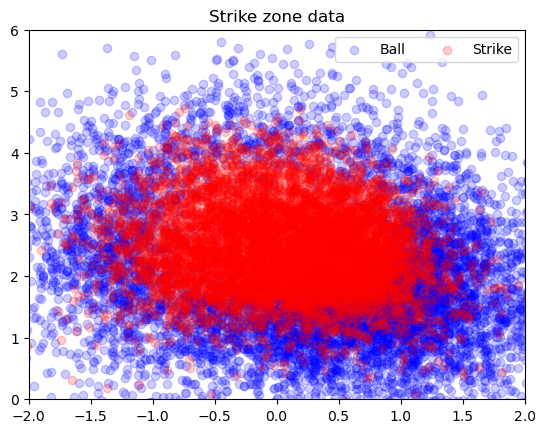

In [10]:
def plot_data(df: pd.DataFrame) -> None:
    balls: pd.DataFrame = df[df.label == 0]
    strikes: pd.DataFrame = df[df.label == 1]
    
    fig, ax = plt.subplots()
    ball_scatter = plt.scatter(balls.plate_x, balls.plate_z, c="b", alpha=0.2)
    strike_scatter = plt.scatter(strikes.plate_x, strikes.plate_z, c="r", alpha=0.2)
    plt.title("Strike zone data")
    plt.legend((ball_scatter, strike_scatter),
           ('Ball', 'Strike'),
           loc='upper right',
           ncol=2,
           fontsize=10)
    ax.set_ylim(0, 6)
    ax.set_xlim(-2, 2)
    plt.show()

plot_data(judge_df_cleaned)

You might notice, that this data distribution makes it unfeasible to use linear decision boundaries. We will instead employ the kernel trick to transform our feature space in order to find a maximum-margin hyperplane between the labels. Here is another visualisation of the procedure:

![Kernel Trick](https://www.researchgate.net/profile/Marouane-Hachimi/publication/340610860/figure/fig4/AS:880021191286786@1586824810950/Non-linear-classifier-using-Kernel-trick-16.ppm)

We now have a clean and handy dataframe with all the data, that we're interested in. Let's get ready to feed it into our SVM.

Assign the part of the dataframes, which we will use to predict the label, to a new variable called `features`. Also assign the column with the labels to a new variable called `labels`.

In [11]:
features: pd.DataFrame = judge_df_cleaned[["plate_x", "plate_z"]]
labels: pd.Series = judge_df_cleaned["label"]

print(features.head())
print(labels.head())

   plate_x  plate_z
1     1.06     3.01
2     0.65     3.17
5    -0.34     2.00
7     0.68     2.49
8     0.07     2.20
1    1.0
2    1.0
5    1.0
7    1.0
8    1.0
Name: label, dtype: float64


In [12]:
# Test cell

assert features is not None, "Your features are not defined. Create a new dataframe called features by selecting the 'plate_x' and 'plate_z' columns from judge_df_cleaned"
assert labels is not None, "Your labels are not defined. Create a new series called labels by selecting the 'label' column from judge_df_cleaned"

assert features.columns.to_list() == ["plate_x", "plate_z"], "The plate x and z data should be in the features"
assert labels.name == "label", "The label column could be the labels variable"

We want to test the quality of your model independently later on, so we will split our data in a training-set and a test-set again. Use the appropiate function a split your data. The test-set should contain 20% of the total data. Make sure, that the data was split correctly by having a look at the shape of the resulting matrices/arrays.

Assign features and labels of your subsets to the variables `X_train, X_test, y_train, y_test`. To pass the test cell the sample size and amount of features has to be correct.

In [13]:
X_train: np.ndarray
X_test: np.ndarray
y_train: np.ndarray
y_test: np.ndarray

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

print("features shape:", features.shape)
print("features_train shape:", X_train.shape)
print("features_test shape:", X_test.shape)

print("labels shape:", labels.shape)
print("labels_train shape:", y_train.shape)
print("labels_test shape:", y_test.shape)


features shape: (14552, 2)
features_train shape: (11641, 2)
features_test shape: (2911, 2)
labels shape: (14552,)
labels_train shape: (11641,)
labels_test shape: (2911,)


In [15]:
# Test cell

test_size: float = 0.2
train_size: float = 1 - test_size

assert X_train is not None, "Your X_train is not defined. Use the train_test_split function to split the features into training and testing sets"
assert X_test is not None, "Your X_test is not defined. Use the train_test_split function to split the features into training and testing sets"
assert y_train is not None, "Your y_train is not defined. Use the train_test_split function to split the labels into training and testing sets"
assert y_test is not None, "Your y_test is not defined. Use the train_test_split function to split the labels into training and testing sets"

assert len(X_train.shape) == 2, "Your training set is not a 2D-Matrix"
assert len(X_test.shape) == 2, "Your test set is not a 2D-Matrix"
if (len(X_train.shape) == 2) and (len(X_test.shape) == 2):
    assert X_train.shape[1] == 2, "Your training set should have 2 columns"
    assert X_test.shape[1] == 2, "Your test set should have 2 columns"
    assert y_train.shape == (int(labels.shape[0] * train_size),), f"y_train shape is {y_train.shape} instead of {(int(labels.shape[0] * train_size),)}. Your training set should contain {train_size*100}% of the data"
    assert y_test.shape == ((int(labels.shape[0] * test_size))+1,), f"y_test shape is {y_test.shape} instead of {((int(labels.shape[0] * test_size))+1,)} . Your test set should contain {test_size*100}% of the data"
    assert X_train.shape == (int(features.shape[0] * train_size), features.shape[1]), f"X_train shape is {X_train.shape} instead of {(int(features.shape[0] * train_size), features.shape[1])}"
    assert X_test.shape == ((int(features.shape[0] * test_size)+1), features.shape[1]), f"X_test shape is {X_test.shape} instead of {((int(features.shape[0] * test_size)+1), features.shape[1])}"

### Model training

Now it's finally time to create our model, train it with our data, predict our test set and evaluate the models accuracy. Use an `rbf-kernel`, `C = 2`, and `gamma = 2` for now.

Save the model to a variable called `model`, use the appropiate hyper parameters and fit the model to pass the test cell. Assign the prediction of the test set to a variable called `predictions_test` and it's accuracy to `accuracy_test`.

In [16]:
model: SVC = SVC(kernel = "rbf", C=2, gamma=2)
model.fit(X_train, y_train)

predictions_test: np.ndarray = model.predict(X_test)

accuracy_test: float = model.score(X_test, y_test)
accuracy_test: float = metrics.accuracy_score(predictions_test, y_test) # Alternatively
print(f"Accuracy: {accuracy_test: .2f}")

Accuracy:  0.85


In [17]:
# Test cell

assert model is not None, "model is not defined."
assert model.kernel == "rbf", 'The model kernel should be "rbf"'
assert model.C == 2, "The C hyper parameter should be 2"
assert model.gamma == 2, "The gamma hyper parameter should be 2"
assert hasattr(model, "fit_status_"), "The model is not fitted"

assert predictions_test is not None
assert accuracy_test > 0.7

Also print the confusion-matrix of your predictions as an assessment of the model-performance. Don't forget that labels you want to display are is the list ["Balls", "Strikes"].

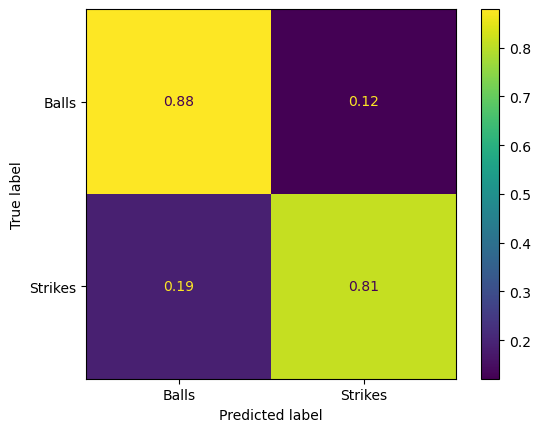

In [ ]:
cm: np.ndarray = confusion_matrix(y_test, predictions_test, normalize='true')
disp: ConfusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Balls", "Strikes"])
disp.plot()
plt.show()

As a final reward you get to plot the decision boundary. Call the ```plot_strike_zone```-function with your cleaned dataframe and your trained model.

c:\Users\lukas\miniconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


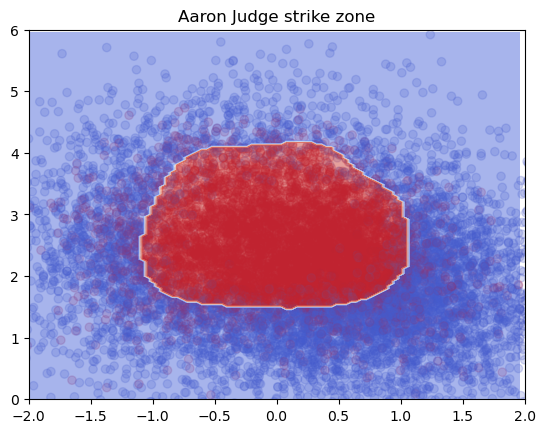

In [ ]:
def plot_strike_zone(df: pd.DataFrame, model: SVC) -> None:
    fig, ax = plt.subplots()
    plt.scatter(df.plate_x, df.plate_z, c=df.label, cmap=plt.cm.coolwarm, alpha=0.2)
    plt.title("Aaron Judge strike zone")
    ax.set_ylim(0, 6)
    ax.set_xlim(-2, 2)
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    h = 0.04
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
    plt.show()

plot_strike_zone(judge_df_cleaned, model)

**Congratulations on building your own SVM model!**

If you are interested in the effects of the hyperparameters: Change the hyperparameters in your model construction, retrain it and plot the decision boundary again.

If your thirst for baseball data is still not quenched(understandably), feel free to compare Judge's strike zone to that of a smaller player like Jose Altuve.